In [1]:
import os
from glob import glob
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    open_file,
    cut_jumps,
    rescale_coord
    )

wall_perc = 0.1

#####  parameters to change

In [3]:
DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'preprocessed_dataset'

# 1. open files
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

# 2. cut_jumps
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6,show=False)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47,show=False)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2,show=False)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32,show=False)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7,show=False)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3,show=False)

dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val
 
# 3. rescale x and y coords to fit area size 
AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_dict.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    # df['x'] = rescaled_x
    # df['y'] = rescaled_y  # NOTE: it should fix warning for Varya's version of pandas
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, [df]
    
DROP_THRESHOLD = 5
dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                 'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                 'tr91': 0.035, 'tr92': 0.035}

subtraj_dfs_dict = {}
for k, df in rescaled_dfs_dict.items():
    k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                       traj_drop_threshold=DROP_THRESHOLD)
    subtraj_dfs_dict[k] = df_subtraj  # list of dfs


NEW_DT - 1/ new sampling rate 



In [5]:
# 5. resample to required dt


# 6. add angles, delta_angles, step len, 
def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,
    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dfs_dict_with_angles = {}
for k, df in subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        df_step = add_step_length(sub_traj_df)
        subtraj_list.append(df_step)
    dfs_dict_with_angles[k] = subtraj_list

# 7. sort by areas of open field
def sort_walls_area(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 40
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 30
            else:
                tr['near_wall'].iloc[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 10
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 20
            else:
                tr['near_wall'].iloc[i] = 2
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 1
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 3
    return tr

from utils.plotting import plot_wall_sorted_samples

dfs_with_walls = {}
bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40}   

for k, df in dfs_dict_with_angles.items():
    subtraj_list = []
    for sub_df in df:
        sub_df = sort_walls_area(sub_df, bord40, wall_perc)
        subtraj_list.append(sub_df)
    dfs_with_walls[k] = subtraj_list

dict_keys(['tr11', 'tr12', 'tr2', 'tr3', 'tr4', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92'])


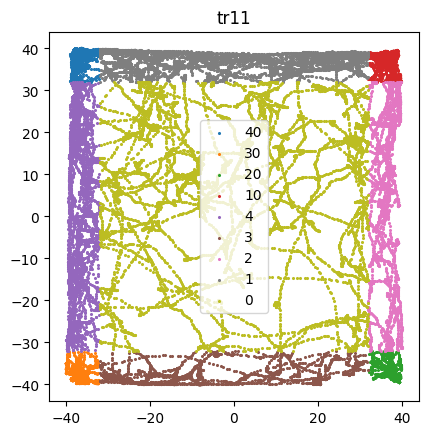

In [8]:
print(dfs_with_walls.keys())

merged_tr11 = pd.concat(dfs_with_walls['tr11'])
plot_wall_sorted_samples(merged_tr11, 'tr11')

In [18]:
# 7.5 highlight pauses. 
#PARAMETER TO CHANGE !!!
#исправленная версия, т к у мыши 9 2 когда она сидит длина сумм шагов чуть меньше 4
max_step_of_stop = 4

# sliding window for 7.5 highlight pauses. we define pause as situation when sum of mice step len is less than 3?
#parameter for dx (0.5 s: sum of dx in 0.034 s). we suggest that velocity more than 20/s is not a pause. sounds strange
#d пока взят наобум
#import math
d = 10 # TODO what is it???
window_size = round(0.5/0.034)


def movementOrNot(step_sum, max_step_of_stop):
    if step_sum == -100:
        out = 'NotDefined'
    elif step_sum > max_step_of_stop:
        out = 'Move'
    elif step_sum <= max_step_of_stop:
        out = 'Stop'
    else:
        out = 'error'
    return out

#если в цикле менять что-то в ldf, то изменения вносятся и в оригинальный словарь subtraj_dfs_dict??? или нет?
#len_all = {}
#len_stops = {}
dfs_stop = {}
for k, df in dfs_with_walls.items():
    #la = 0
    #ls = 0
    sub_list = []
    for ldf in df:
        #ldf = add_step_length(ldf)
        ldf = ldf.iloc[1:]
        if len(ldf) >= window_size:
            ldf = ldf.copy()
            ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
            ldf['step_sum_0.5'] = ldf['step_sum_0.5'].fillna(-100)
            func = np.vectorize(movementOrNot)
            ldf['movement'] = func(ldf['step_sum_0.5'], max_step_of_stop)
            sub_list.append(ldf)
            #если разница 0.5 или больше смотрим чтобы сумма дх была не больше max_step_of_stop (2?)
            #все эти точки исключаем как паузу
            #или все таки сделать паузу после выделения шагов но зачем вроде хуже
        dfs_stop[k] = sub_list

In [20]:
## Save distributions
with open(PREPROC_DATA_DIR + '/preprocessed_dfs_subtraj_for_marks.pkl', 'wb') as fp:    
    pickle.dump(dfs_stop, fp)

### Overall statistics

In [27]:
# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has angle 0 and delta angle 0
#ну он хоть как-то соотвествует видео)))
merg_resampled_dfs_dict = {}
mv = []
mv_wall = []
mv_cent = []
mv_corn = []
st = []
for k, df in dfs_stop.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)

for k, df in merg_resampled_dfs_dict.items():
    print(k,'perc of move', len(df.loc[df['movement']=='Move'])/len(df))
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    
    wall_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=1)&(df['near_wall']<=4)])\
    /len(df.loc[(df['near_wall']>=1)&(df['near_wall']<=4)])
    corn_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=10)&(df['near_wall']<=40)])\
    /len(df.loc[(df['near_wall']>=10)&(df['near_wall']<=40)])
    cent_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']==0)])\
    /len(df.loc[(df['near_wall']==0)])
    mv_wall.append(wall_m)
    mv_cent.append(cent_m)
    mv_corn.append(corn_m)
    
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    print(k,'perc of stop', len(df.loc[df['movement']=='Stop'])/len(df))
    st.append(len(df.loc[df['movement']=='Stop'])/len(df))
print('move, mean',np.mean(mv))
print('stop, mean',np.mean(st))
print('mv_wall',mv_wall)
print('move near wall, mean',np.mean(mv_wall))
print('move near center, mean',np.mean(mv_cent))
print('move near corner, mean',np.mean(mv_corn))

for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].loc[merg_resampled_dfs_dict[k]['movement']=='Move']

tr11 perc of move 0.6077122094129285
tr11 perc of stop 0.39204048244112166
tr12 perc of move 0.5460085313833029
tr12 perc of stop 0.45300121876904326
tr2 perc of move 0.41811993269083675
tr2 perc of stop 0.5816314823313447
tr3 perc of move 0.750366185394434
tr3 perc of stop 0.015693659761456372
tr4 perc of move 0.7118447053353482
tr4 perc of stop 0.15064512379402534
tr5 perc of move 0.7519166131651498
tr5 perc of stop 0.1832773140979644
tr6 perc of move 0.6840903269871084
tr6 perc of stop 0.2853880303935798
tr7 perc of move 0.7557975487170443
tr7 perc of stop 0.2201304999559122
tr91 perc of move 0.8055195951512298
tr91 perc of stop 0.18122082303558118
tr92 perc of move 0.9293007566779105
tr92 perc of stop 0.061217977937824776
move, mean 0.6960676404915294
stop, mean 0.25242466125178536
mv_wall [0.7201066260472201, 0.6432583101052544, 0.46176494313140276, 0.7381537381537382, 0.7735737511084836, 0.8418027324225258, 0.7092842689755776, 0.7997091419688079, 0.8251290767405317, 0.97139303482